In [6]:
import src.tmlsm.data_t2 as td2
import importlib
from pathlib import Path
import os
import jax.numpy as jnp
import src.tmlsm.visualization as vis
importlib.reload(vis)
importlib.reload(td2)
import jax
import jax.random as jrandom
import src.tmlsm.models as tm
import src.tmlsm.losses as tl
importlib.reload(tm)
importlib.reload(tl)

<module 'src.tmlsm.losses' from 'c:\\Users\\fromm\\OneDrive\\Master\\Tutorium Machine Learning\\ML-Tutorial-WS25_26\\ffnn_introduction\\src\\tmlsm\\losses.py'>

In [7]:
# Global Variables

# Define the structural tensor
G_ti = jnp.array([[4.0, 0.0, 0.0],
                  [0.0, 0.5, 0.0],
                  [0.0, 0.0, 0.5]])

master_key = jrandom.PRNGKey(0)

In [8]:
current_folder = Path(os.getcwd())
base_path = current_folder.parent / "hyperelasticity" / "data"
base_path = str(base_path)
# base_path = r"C:\Users\alexp\Desktop\#Uni\Master 1\5. Semester\PAML Tutorium\Repo\ML-Tutorial-WS25_26\hyperelasticity\data"
# Lukas C:\Users\fromm\OneDrive\Master\Tutorium Machine Learning
# Alex C:\Users\alexp\Desktop\Tutorium Neu
# Alex_home C:\Users\alexp\Desktop\#Uni\Master 1\5. Semester\PAML Tutorium\Repo\ML-Tutorial-WS25_26\hyperelasticity\data
F_uni, P_uni, W_uni = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\uniaxial.txt"))
F_ps, P_ps, W_ps = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\pure_shear.txt"))
F_bi, P_bi, W_bi = td2.load_hyperelastic_data(os.path.join(base_path, r"calibration\biaxial.txt"))
F_bi_test, P_bi_test, W_bi_test = td2.load_hyperelastic_data(os.path.join(base_path, r"test\biax_test.txt"))

# right Cauchy Green tensor
C_uni = F_uni.transpose(0, 2, 1) @ F_uni 
C_ps = F_ps.transpose(0, 2, 1) @ F_ps 
C_bi = F_bi.transpose(0, 2, 1) @ F_bi 
C_bi_test = F_bi_test.transpose(0, 2, 1) @ F_bi_test

# Convert to JAX array
F_bi_jx = jnp.array(F_bi)
P_bi_jx = jnp.array(P_bi)
C_bi_jx = jnp.array(C_bi)

F_uni_jx = jnp.array(F_uni)  
P_uni_jx = jnp.array(P_uni)
C_uni_jx = jnp.array(C_uni)

F_ps_jx = jnp.array(F_bi)  
P_ps_jx = jnp.array(P_ps)
C_ps_jx = jnp.array(C_ps)

F_bi_test_jx = jnp.array(F_bi)  
P_bi_test_jx = jnp.array(P_bi_test)
C_bi_test_jx = jnp.array(C_bi_test)

#compute invariants
bi_invariants_computed = td2.compute_all_invariants(F_bi_jx, G_ti)
uni_invariants_computed = td2.compute_all_invariants(F_uni_jx, G_ti)
ps_invariants_computed = td2.compute_all_invariants(F_ps_jx, G_ti)
bi_test_invariants_computed = td2.compute_all_invariants(F_bi_test_jx, G_ti)

# Load reference data
invariants_reference = td2.load_invariants(
    os.path.join(base_path, r"invariants\I_biaxial.txt")
)

# W_reference = td2.compute_analytical_W(td2.load_invariants(r"C:\Users\alexp\Desktop\Tutorium Neu\ML-Tutorial-WS25_26\hyperelasticity\data\invariants\I_biaxial.txt"))
# W_computed = td2.compute_analytical_W(invariants_computed)
# print(jnp.max(jnp.abs(W_reference - W_computed)))

### 1.2 Comparison Invariants loaded and Computed

In [ ]:
# # Test with biaxial data
# F_jax = jnp.array(F_bi)  # Convert to JAX array
# invariants_computed = td2.compute_all_invariants(F_jax, G_ti)

# # Load reference data
# invariants_reference = td2.load_invariants(
#     os.path.join(base_path, r"invariants\I_biaxial.txt")
# )

# print("Computed invariants (first 5 rows):")
# print(invariants_computed[:5])
# print("\nReference invariants (first 5 rows):")
# print(invariants_reference[:5])
# print("\nMaximum error:")
# print(jnp.max(jnp.abs(invariants_computed - invariants_reference)))

# P = td2.compute_P_batch(F_jax,G_ti)

# print("test" , P.shape)

Computed invariants (first 5 rows):
[[3.1578465  0.41875207 2.4805038  3.0964804 ]
 [3.1446934  0.4289451  2.500906   3.1560528 ]
 [3.1314847  0.43914768 2.5216777  3.2147076 ]
 [3.118251   0.44935584 2.542835   3.272414  ]
 [3.1050224  0.4595653  2.5643923  3.3291395 ]]

Reference invariants (first 5 rows):
[[3.15784645 0.41875213 2.48050404 3.09648037]
 [3.14469337 0.42894509 2.50090599 3.15605283]
 [3.13148451 0.43914765 2.52167773 3.21470737]
 [3.11825132 0.44935581 2.542835   3.27241397]
 [3.10502267 0.45956534 2.56439209 3.32913971]]

Maximum error:
1.9073486e-06
test (199, 3, 3)


### Uniaxial Load case

In [9]:
vis.plot_F_diagonals(C,components=["F11","F12"])
vis.plot_F_diagonals(F_bi_test,components=["F11","F22","F33"])

vis.plot_F_diagonals(F_bi,components=["F11","F22","F33"])
vis.plot_F_diagonals(F_bi_test,components=["F11","F22","F33"])

vis.plot_F_diagonals(F_bi,components=["F22"])
vis.plot_F_diagonals(F_bi_test,components=["F22"])

vis.plot_F_diagonals(F_bi,components=["F33"])
vis.plot_F_diagonals(F_bi_test,components=["F33"])

NameError: name 'C' is not defined

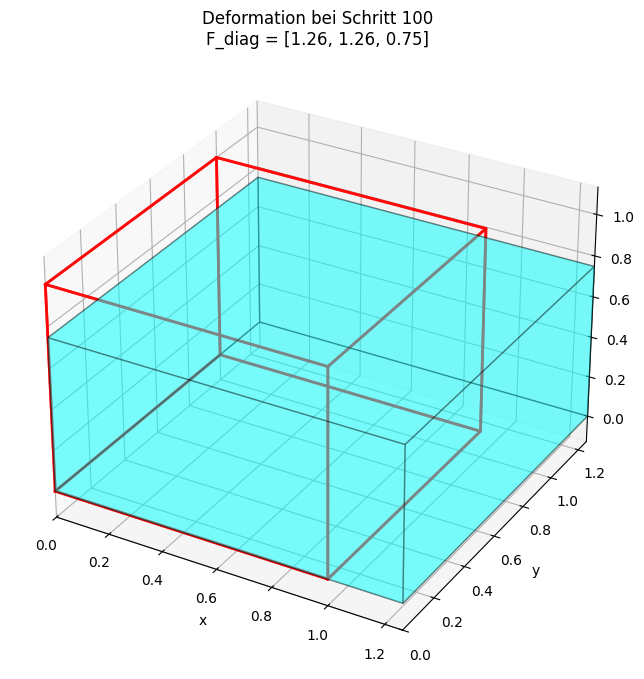

In [ ]:
vis.visualize_deformation_3d(F, step_index=100)

### Task 2

In [10]:
#create P_cal and C_cal datasets for training from all loadcases

# Combine all right Cauchy–Green tensors for calibration
C_cal = jnp.concatenate([C_uni_jx, C_ps_jx, C_bi_jx], axis=0)

# Combine all Piola stresses for calibration
P_cal = jnp.concatenate([P_uni_jx, P_ps_jx, P_bi_jx], axis=0)


In [11]:
# ------------------------------------------------------------
# Convert C (3x3) → vector of 6 independent components
# ------------------------------------------------------------
def C_to_six(C):
    return jnp.array([
        C[0,0], C[1,1], C[2,2],
        C[0,1], C[0,2], C[1,2],
    ])


# ------------------------------------------------------------
# Prepare training data for MS
# F_cal, P_cal, C_cal come from your Task 1 loading code
# ------------------------------------------------------------

X_MS = jax.vmap(C_to_six)(C_cal)   # shape (N,6)
Y_MS = P_cal.reshape(len(P_cal), 9)  # shape (N,9)

# ------------------------------------------------------------
# Build the MS model (uses your existing build() function)
# ------------------------------------------------------------
def build_MS_model(model_key, num_layers, num_nodes):
    model = tm.build(
        key=model_key,
        input_dim=6,             # 6 components of C
        output_dim=9,            # 9 components of P
        num_hidden_layers=num_layers,
        nodes_per_layer=num_nodes,
        activations=jax.nn.softplus,
        constrain_icnn_weights=False   # MS is NOT an ICNN
    )
    return model


# ------------------------------------------------------------
# Train MS model — same structure as Task 1
# ------------------------------------------------------------
def train_MS(model, train_key, steps=100000, batch_size=32, lr=1e-3):
    trained_model, history = tm.train_model(
        model=model,
        train_data=(X_MS, Y_MS),
        key=train_key,
        steps=steps,
        batch_size=batch_size,
        learning_rate=lr,
        loss_fn=tl.MSE(),
    )
    return trained_model, history

In [12]:
model_key_1, train_key_1 = jrandom.split(master_key, 2)

M_S_model = build_MS_model(model_key_1, num_layers=3, num_nodes=16)
M_S_trained, M_S_history = train_MS(M_S_model, train_key_1, steps=300000)

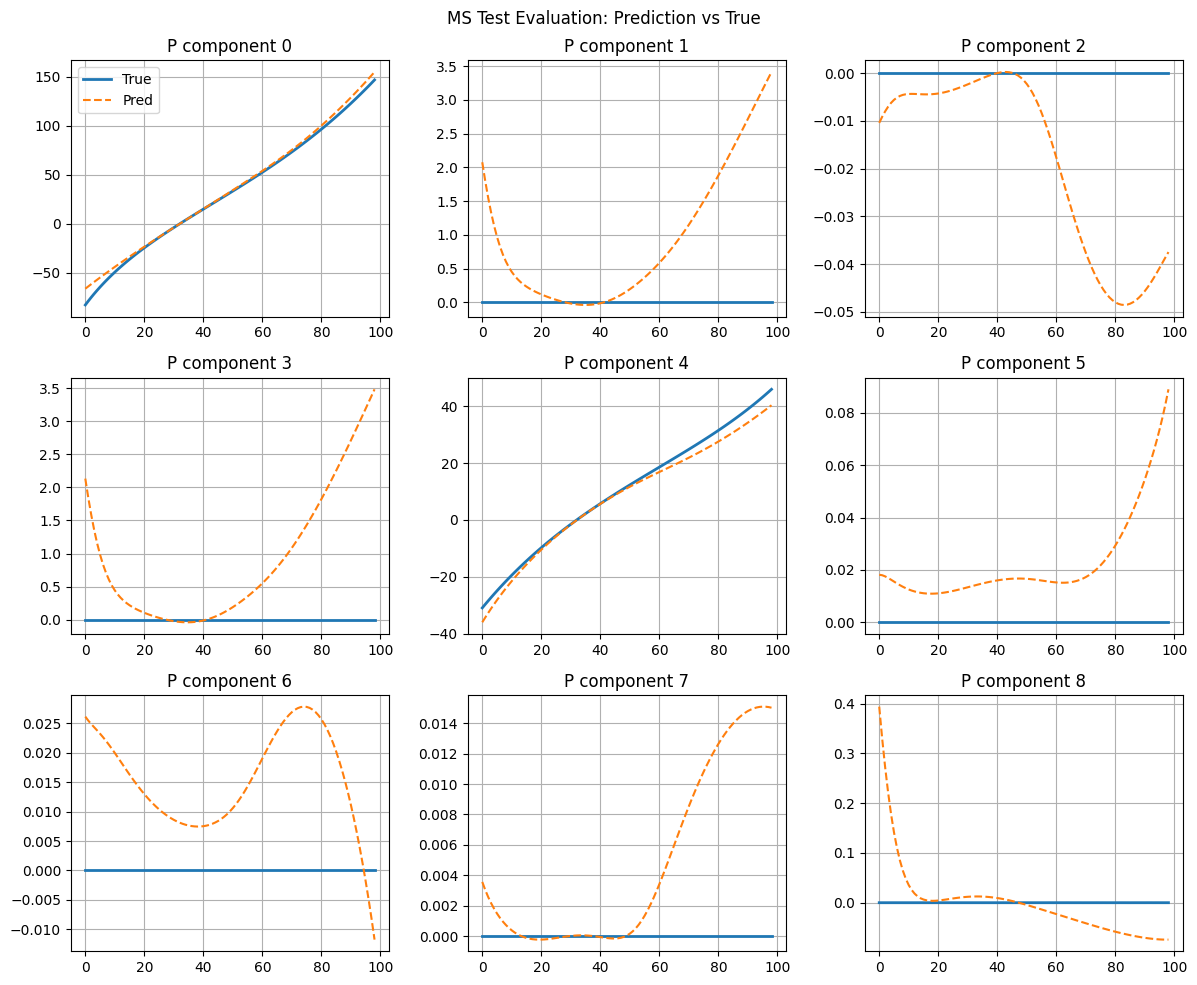

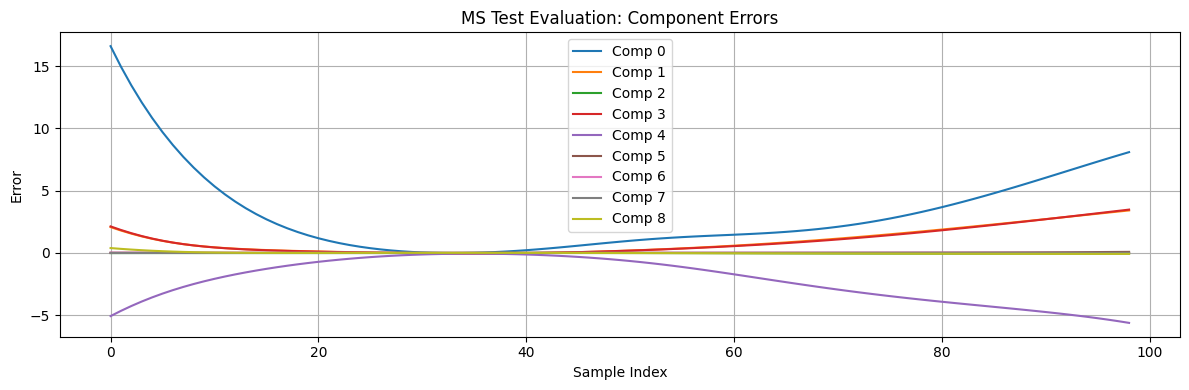

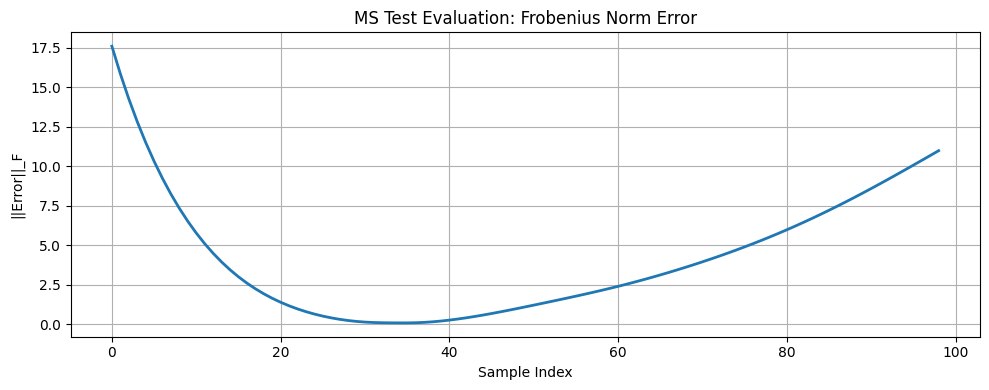

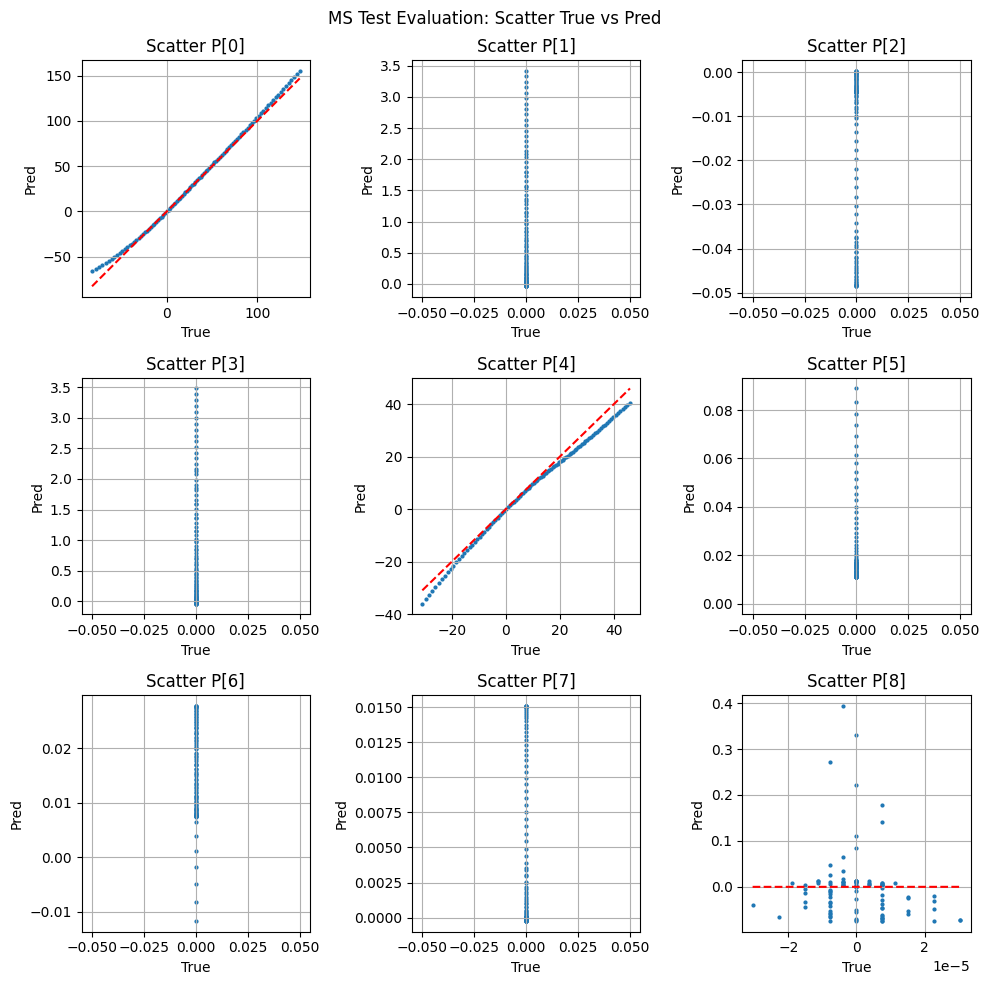

{'mae': Array(0.812087, dtype=float32), 'rmse': Array(1.9248316, dtype=float32), 'max_error': Array(16.593285, dtype=float32), 'frob_mean': Array(4.2123404, dtype=float32)}


In [13]:
#making predictions on bi_test and evaluating
X_test_MS = jax.vmap(C_to_six)(C_bi_test_jx)   # shape (N,6)
Y_test_MS = P_bi_test_jx.reshape(len(P_bi_test_jx), 9)  # shape (N,9)

test_pred = jax.vmap(M_S_trained)(X_test_MS)

metrics = vis.evaluate_MS_predictions(Y_test_MS, test_pred)

print(metrics)

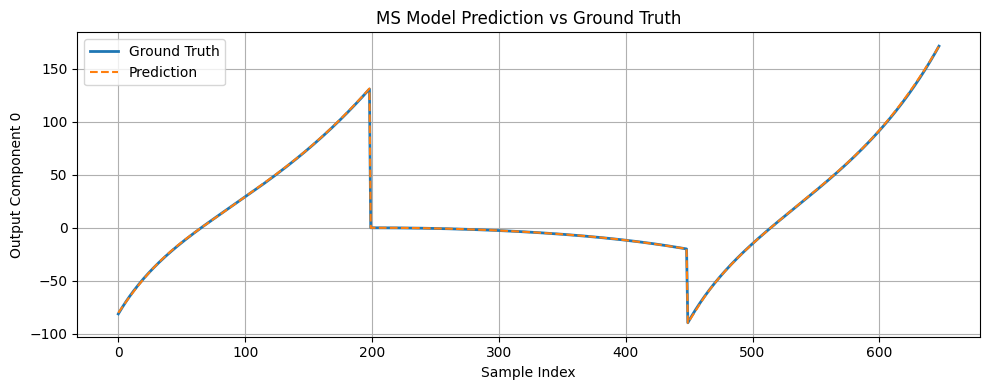

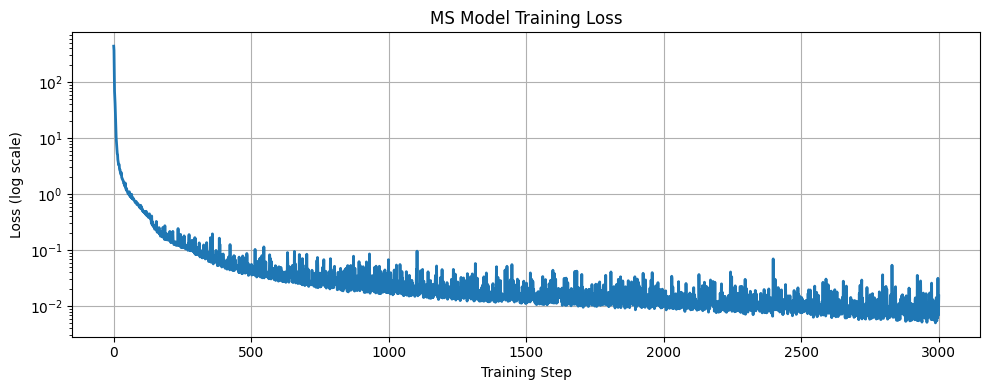

In [14]:
# Suppose X_MS = inputs (C as 6-vec)
# and     Y_MS = outputs (P as 9-vec)

vis.plot_model_and_history(
    M_S_trained,
    X_MS,
    Y_MS,
    M_S_history,
    title_model="MS Model Prediction vs Ground Truth",
    title_history="MS Model Training Loss"
)

### Task 2.3 Loss weighted strategy

In [15]:
#Compute weights
w_uni = td2.compute_path_weight(P_uni_jx)
w_ps  = td2.compute_path_weight(P_ps_jx)
w_bi  = td2.compute_path_weight(P_bi_jx)

#Compute 1/w
w_uni_inv = 1 / w_uni
w_ps_inv  = 1 / w_ps
w_bi_inv  = 1 / w_bi

#assign weights to samples as jnp array
weights_uni = w_uni_inv * jnp.ones(len(P_uni_jx))
weights_ps  = w_ps_inv  * jnp.ones(len(P_ps_jx))
weights_bi  = w_bi_inv  * jnp.ones(len(P_bi_jx))

sample_weights = jnp.concatenate([weights_uni, weights_ps, weights_bi])

In [16]:
#format training data
train_data = (X_MS, (Y_MS, sample_weights))
#use weighted loss function
loss_fn = tl.WeightedMSE(sample_weights)

model_key_2, train_key_2 = jrandom.split(master_key, 2)

M_w_model = build_MS_model(key=model_key_2, num_hidden_layers=3, nodes_per_layer=16)
trained_M_w, history_M_w = train_MS(train_data=train_data, key=train_key_2, steps=100000, loss_fn=loss_fn)

TypeError: build_MS_model() got an unexpected keyword argument 'key'